In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gwpy.segments import DataQualityFlag
from gwpy.time import to_gps,tconvert
from gwpy.timeseries import TimeSeriesDict,TimeSeries,StateTimeSeries
import matplotlib

In [10]:
import seaborn as sns
import matplotlib.style as style
sns.set_style('whitegrid')
#plt.style.use('fivethirtyeight')

# Hanford

### Retrieve Observing Flags

In [4]:
def o_flagsH1(epoch):
    ground = TimeSeriesDict.read('files/{}_H1data.hdf5'.format(epoch))
    useism = ground['H1:ISI-GND_STS_ETMY_X_BLRMS_100M_300M.mean']
    observe_flag = DataQualityFlag.query('H1:DMT-ANALYSIS_READY:1',useism.times[0],useism.times[-1]).active
    return observe_flag

observe_flags = {}
epochs = ['O3B1','O3B2']
for i in epochs:
    observe_flags[i] = o_flagsH1(i)

In [7]:
def groundBetweenFlag(useism,equake,useism_low,useism_high,equake_thresh):
    low = abs(useism)>useism_low*useism.unit
    high = abs(useism)<useism_high*useism.unit
    quake = abs(equake)<equake_thresh*equake.unit
    flag = StateTimeSeries([all(t) for t in zip(low.value,high.value,quake.value)],t0=useism.t0,dt=60).to_dqflag().active
    return flag

def calculate_duration(seglist):
    rundur = 1e-9
    for i in seglist:
        rundur+=(i.end - i.start)
    return rundur

def observeOnly(data,segments,Times=False):
    observe = []
    times   = []
    for start,end in segments:
        begin = start - start%60
        finish = end - end%60
        idx_lo = np.where(data.times.value==begin)[0][0]
        idx_hi = np.where(data.times.value==finish)[0][0]
        observe.extend(data.value[idx_lo:idx_hi])
        times.extend(data.times.value[idx_lo:idx_hi])
    if Times:
        return np.array(observe),np.array(times)
    else:
        return np.array(observe)

def numGlitches(useism,equake,useism_low,useism_high,equake_thresh,glitches,observeFlag):
    useismObserve = TimeSeries(observeOnly(useism,observeFlag),dt=60)
    equakeObserve = TimeSeries(observeOnly(equake,observeFlag),dt=60)
    
    groundFlag = groundBetweenFlag(useism,equake,useism_low,useism_high,equake_thresh)
    groundObserveFlag = groundBetweenFlag(useismObserve,equakeObserve,useism_low,useism_high,equake_thresh)
        
    num_glitches = 0
    for i in groundFlag:
        num_glitches += len(glitches[(glitches>=i.start) & (glitches<=i.end)])  
    
    duration = calculate_duration(groundObserveFlag)
             
    rate = round(float(num_glitches/duration)*3600,5)
    return num_glitches, int(duration), rate
    
class GlitchRates:
    
    def __init__(self,epoch,oFlags,useism_low,useism_high,equake_thresh):
        glitches = pd.read_csv('files/glitchesH1_{}.csv'.format(epoch))  ### added H1
        glitches = glitches.drop_duplicates(keep='first', subset='GPStime')
        glitches = glitches[glitches.snr>10]
        glitches_times = glitches['GPStime']

        ground = TimeSeriesDict.read('files/{}_H1data.hdf5'.format(epoch)) ## added H1
        self.useism = ground['H1:ISI-GND_STS_ETMY_X_BLRMS_100M_300M.mean']
        self.useism2 = ground['H1:ISI-GND_STS_ETMY_X_BLRMS_300M_1.mean']
        self.equake = ground['H1:ISI-GND_STS_ETMY_Z_BLRMS_30M_100M.mean']
        #self.wind   = ground['H1:PEM-EY_WIND_WEATHER_MPH.mean']

        self.glitches,self.duration,self.rate = numGlitches(self.useism,self.equake,useism_low,useism_high,
                                                          equake_thresh,glitches_times,oFlags[epoch])

In [8]:
epochs = ['O3B1','O3B2']

quake = 80
levels = np.arange(0,2250,250)

rates = {}
for i in epochs:
    rates[i] = []

for i in range(len(levels[1:])):
    low = levels[i]
    high = levels[i+1]
    for i in epochs:
        rates[i].append(round(GlitchRates(i,observe_flags,low,high,quake).rate,2))

[0 1 2 3 4 5 6 7]


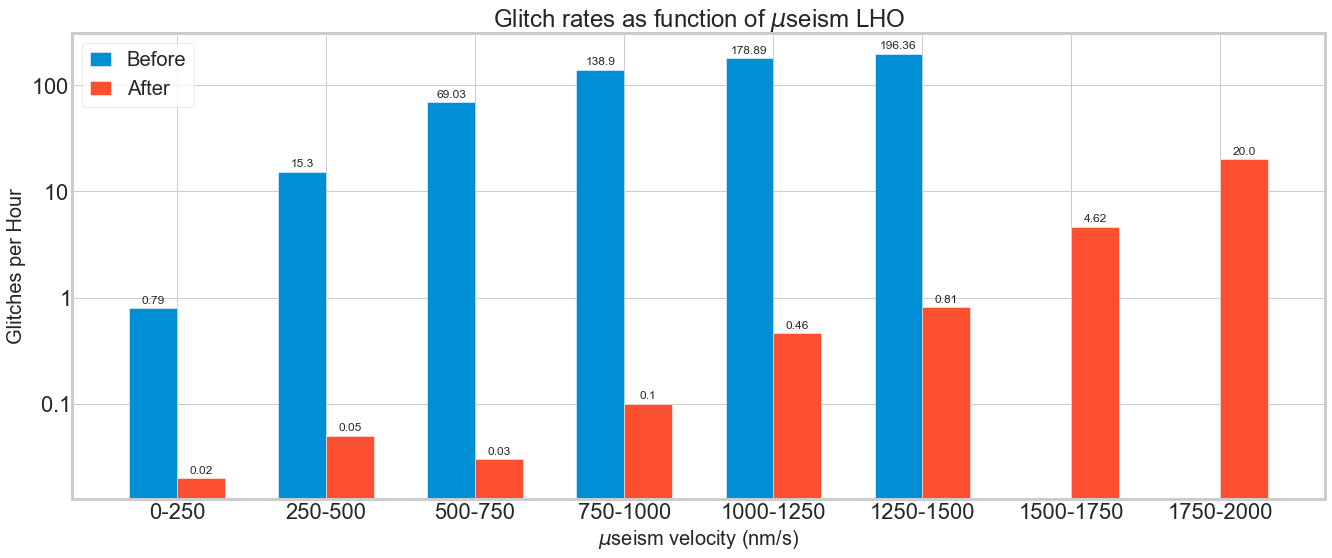

In [12]:
labels= []
for i in range(len(levels[1:])):
    labels.append('{}-{}'.format(levels[i],levels[i+1]))
    
x = np.arange(len(labels))  # the label locations
width = 0.32  # the width of the bars
print(x)
fig, ax = plt.subplots(figsize=(20,8))
rects2 = ax.bar(x, rates['O3B1'], width, label='Before')
rects3 = ax.bar(x + width, rates['O3B2'], width, label='After')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(r'$\mu$seism velocity (nm/s)',fontsize=20)
ax.set_ylabel('Glitches per Hour',fontsize=20)
ax.set_yscale('log')
ax.set_title(r'Glitch rates as function of $\mu$seism LHO',fontsize=24)
ax.set_xticks(x+width/2)
ax.set_xticklabels(labels)
#ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.legend(fontsize='x-large',loc='upper left')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height != 0:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',fontsize=12)

#autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

#fig.tight_layout()
#plt.savefig('./Figures/glitchRatesH1.png')

plt.show()

# Livingston

### Retrieve Observing Flags

In [13]:
def o_flagsL1(epoch):
    ground = TimeSeriesDict.read('files/{}_data.hdf5'.format(epoch))  ## for L1
    useism = ground['L1:ISI-GND_STS_ETMY_Y_BLRMS_100M_300M.mean']
    observe_flag = DataQualityFlag.query('L1:DMT-ANALYSIS_READY:1',useism.times[0],useism.times[-1]).active
    return observe_flag

observe_flags = {}
epochs = ['O3B1','O3B2']
for i in epochs:
    observe_flags[i] = o_flagsL1(i)

In [14]:
def groundBetweenFlag(useism,equake,useism_low,useism_high,equake_thresh):
    low = abs(useism)>useism_low*useism.unit
    high = abs(useism)<useism_high*useism.unit
    quake = abs(equake)<equake_thresh*equake.unit
    flag = StateTimeSeries([all(t) for t in zip(low.value,high.value,quake.value)],t0=useism.t0,dt=60).to_dqflag().active
    return flag

def calculate_duration(seglist):
    rundur = 1e-9
    for i in seglist:
        rundur+=(i.end - i.start)
    return rundur

def observeOnly(data,segments,Times=False):
    observe = []
    times   = []
    for start,end in segments:
        begin = start - start%60
        finish = end - end%60
        idx_lo = np.where(data.times.value==begin)[0][0]
        idx_hi = np.where(data.times.value==finish)[0][0]
        observe.extend(data.value[idx_lo:idx_hi])
        times.extend(data.times.value[idx_lo:idx_hi])
    if Times:
        return np.array(observe),np.array(times)
    else:
        return np.array(observe)

def numGlitches(useism,equake,useism_low,useism_high,equake_thresh,glitches,observeFlag):
    useismObserve = TimeSeries(observeOnly(useism,observeFlag),dt=60)
    equakeObserve = TimeSeries(observeOnly(equake,observeFlag),dt=60)
    
    groundFlag = groundBetweenFlag(useism,equake,useism_low,useism_high,equake_thresh)
    groundObserveFlag = groundBetweenFlag(useismObserve,equakeObserve,useism_low,useism_high,equake_thresh)
        
    num_glitches = 0
    for i in groundFlag:
        num_glitches += len(glitches[(glitches>=i.start) & (glitches<=i.end)])  
    
    duration = calculate_duration(groundObserveFlag)
             
    rate = round(float(num_glitches/duration)*3600,5)
    return num_glitches, int(duration), rate
    
class GlitchRates:
    
    def __init__(self,epoch,oFlags,useism_low,useism_high,equake_thresh):
        glitches = pd.read_csv('files/glitches_{}.csv'.format(epoch)) ### For L1
        glitches = glitches.drop_duplicates(keep='first', subset='GPStime')
        glitches = glitches[glitches.snr>10]
        glitches_times = glitches['GPStime']

        ground = TimeSeriesDict.read('files/{}_data.hdf5'.format(epoch))
        self.useism = ground['L1:ISI-GND_STS_ETMY_Y_BLRMS_100M_300M.mean']
        self.useism2 = ground['L1:ISI-GND_STS_ETMY_Y_BLRMS_300M_1.mean']
        self.equake = ground['L1:ISI-GND_STS_ETMY_Z_BLRMS_30M_100M.mean']

        self.glitches,self.duration,self.rate = numGlitches(self.useism,self.equake,useism_low,useism_high,
                                                          equake_thresh,glitches_times,oFlags[epoch])

In [15]:
epochs = ['O3B1','O3B2']

quake = 80
levels = np.arange(0,3000,250)

rates = {}
for i in epochs:
    rates[i] = []

for i in range(len(levels[1:])):
    low = levels[i]
    high = levels[i+1]
    for i in epochs:
        rates[i].append(round(GlitchRates(i,observe_flags,low,high,quake).rate,2))

[0 1 2 3 4 5 6 7 8 9]


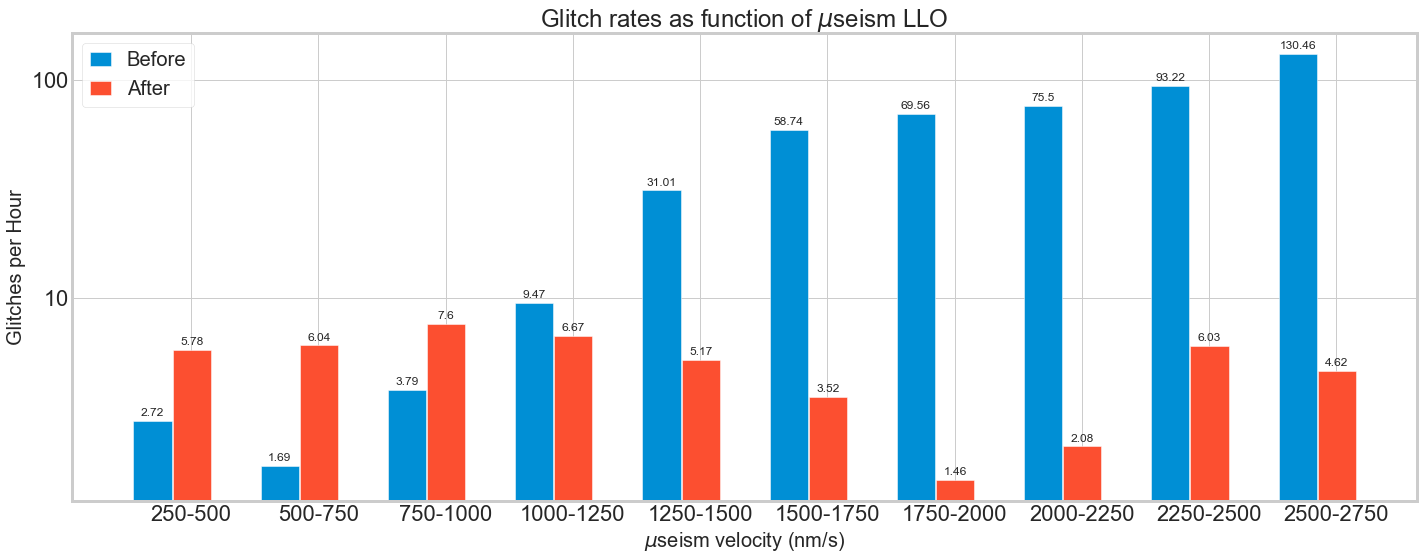

In [17]:
labels= []
for i in range(len(levels[1:])):
    labels.append('{}-{}'.format(levels[i],levels[i+1]))
    
x = np.arange(len(labels[1:]))  # the label locations
width = 0.3  # the width of the bars
print(x)

fig, ax = plt.subplots(figsize=(20,8))
#rects1 = ax.bar(x - width, rates['O3A'], width, label='O3A')
rects2 = ax.bar(x-width/1.95, rates['O3B1'][1:], width, label='Before')
rects3 = ax.bar(x + width/1.95, rates['O3B2'][1:], width, label='After')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(r'$\mu$seism velocity (nm/s)',fontsize=20)
ax.set_ylabel('Glitches per Hour',fontsize=20)
ax.set_yscale('log')
ax.set_title(r'Glitch rates as function of $\mu$seism LLO',fontsize=24)
ax.set_xticks(x+width/2)
ax.set_xticklabels(labels[1:])
#ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.legend(fontsize='x-large',loc='upper left')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=12)

#autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
#plt.savefig('./Figures/glitchRates.png')

plt.show()